In [1]:
import pandas as pd
import math
import os
import pickle
from dataclasses import dataclass

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import Dataset
import torch
#from transformers import AdamW, BertForSequenceClassification, BertTokenizer, DataCollatorWithPadding

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
from transformers import AutoModel, AutoTokenizer

In [9]:
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

## Load database

In [176]:
df_news = pd.read_csv('data/investing_news_high_price.csv')
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760 entries, 0 to 3759
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         3760 non-null   object 
 1   datetime      3760 non-null   object 
 2   media         3760 non-null   object 
 3   is_day_high   3760 non-null   bool   
 4   is_3_high     3760 non-null   bool   
 5   is_7_high     3760 non-null   bool   
 6   is_14_high    3760 non-null   bool   
 7   is_21_high    3760 non-null   bool   
 8   norm_7_mean   3760 non-null   float64
 9   norm_3_mean   3760 non-null   float64
 10  norm_14_mean  3760 non-null   float64
 11  norm_21_mean  3760 non-null   float64
 12  mean_price    3760 non-null   float64
 13  link          3760 non-null   object 
dtypes: bool(5), float64(5), object(4)
memory usage: 282.9+ KB


In [177]:
df_news['datetime'] = pd.to_datetime(df_news['datetime'] , format='%Y-%m-%d' )
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760 entries, 0 to 3759
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         3760 non-null   object        
 1   datetime      3760 non-null   datetime64[ns]
 2   media         3760 non-null   object        
 3   is_day_high   3760 non-null   bool          
 4   is_3_high     3760 non-null   bool          
 5   is_7_high     3760 non-null   bool          
 6   is_14_high    3760 non-null   bool          
 7   is_21_high    3760 non-null   bool          
 8   norm_7_mean   3760 non-null   float64       
 9   norm_3_mean   3760 non-null   float64       
 10  norm_14_mean  3760 non-null   float64       
 11  norm_21_mean  3760 non-null   float64       
 12  mean_price    3760 non-null   float64       
 13  link          3760 non-null   object        
dtypes: bool(5), datetime64[ns](1), float64(5), object(3)
memory usage: 282.9+ KB


## Pre trained BERT tokenizer

In [15]:
%%time
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 2.26 s, sys: 764 ms, total: 3.03 s
Wall time: 27.1 s


#### Text to tensor id

In [16]:
def text_to_tensor(sent):
    """
    """
    input_ids = tokenizer.encode(sent, return_tensors='pt')
    
    with torch.no_grad():
        outs = model(input_ids)
        encoded = outs[0][0, 1:-1] 
        return encoded

## Adaptive AVG POOL

In [17]:
k = 1
l = nn.AdaptiveAvgPool1d(k)
def adaptive_avg_pool1d(l, tensor):
    """
    """
    test = torch.transpose(tensor, 0, 1)
    res  = test.unsqueeze(0)
    output = l(res)
    output = output.squeeze(0)
    output = torch.transpose(output, 0, 1)
    
    return output

In [18]:
p = 1
n = 768
m = nn.AdaptiveAvgPool2d((p,n))
def adaptive_avg_pool2d(m, tensor):
    """
    """
    test = tensor.unsqueeze(0)
    test = test.unsqueeze(0)
    output = m(test)
    output = output.squeeze(0)
    output = output.squeeze(0)
    
    return output

In [200]:
df_news.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
norm_7_mean,940.0,-0.016028,0.012854,-0.064871,-0.022780,-0.014827,-0.007564,0.014062
norm_3_mean,940.0,-0.009482,0.005366,-0.040203,-0.011427,-0.007688,-0.005984,-0.004119
norm_14_mean,940.0,-0.019270,0.024183,-0.089834,-0.031590,-0.016351,-0.002846,0.032680
norm_21_mean,940.0,-0.020056,0.033058,-0.112788,-0.035505,-0.014427,0.001042,0.046253
mean_price,940.0,1103.204846,246.503201,816.500000,895.875000,1001.875000,1353.188750,1641.185000
class,940.0,0.354255,1.589044,-1.000000,-1.000000,-1.000000,2.000000,6.000000


In [199]:
len(df_news)

940

In [180]:
df_news = df_news.query('norm_3_mean < -0.004114')

In [181]:
%%time
df_news = df_news.query('is_3_high == False')
X_ada = []
for headline in df_news['title'].values:
    X_ada.append(np.array(adaptive_avg_pool1d(l,text_to_tensor(headline))[0]))

CPU times: user 6min 40s, sys: 1.42 s, total: 6min 42s
Wall time: 1min 43s


## DBSCAN

In [187]:
from sklearn.cluster import DBSCAN

#### Finding good value for eps and min_samples

In [188]:
from sklearn.neighbors import NearestNeighbors

#### cheking dists one to one

In [189]:
%%time
neigh = NearestNeighbors(n_neighbors=2, p = 2)
nbrs = neigh.fit(X_ada)
distances, indices = nbrs.kneighbors(X_ada)

CPU times: user 1.46 s, sys: 72 µs, total: 1.46 s
Wall time: 1.47 s


In [190]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

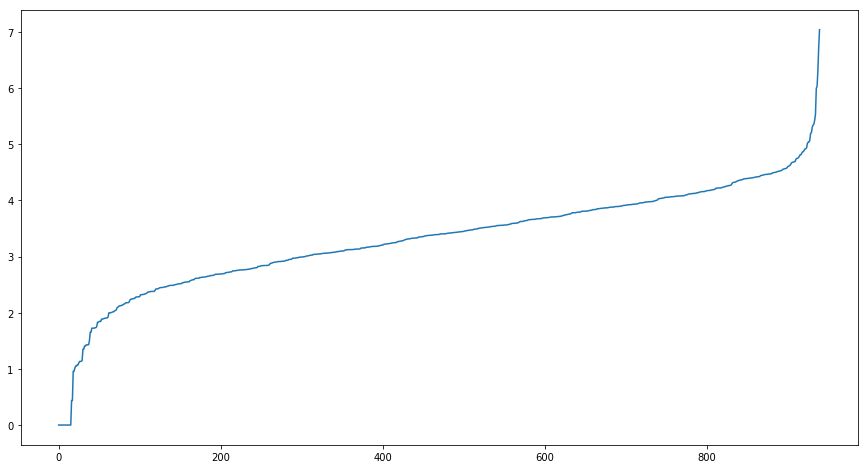

In [191]:
#p = 1
plt.figure(figsize=(15,8))
plt.plot(distances)

#### Run DBSCAN

In [192]:
%%time
clustering = DBSCAN(eps = 3.5, min_samples = 5).fit(X_ada)

CPU times: user 1.77 s, sys: 0 ns, total: 1.77 s
Wall time: 1.78 s


In [193]:
np.unique(clustering.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [194]:
len(clustering.labels_)

940

In [195]:
df_news['class'] = clustering.labels_

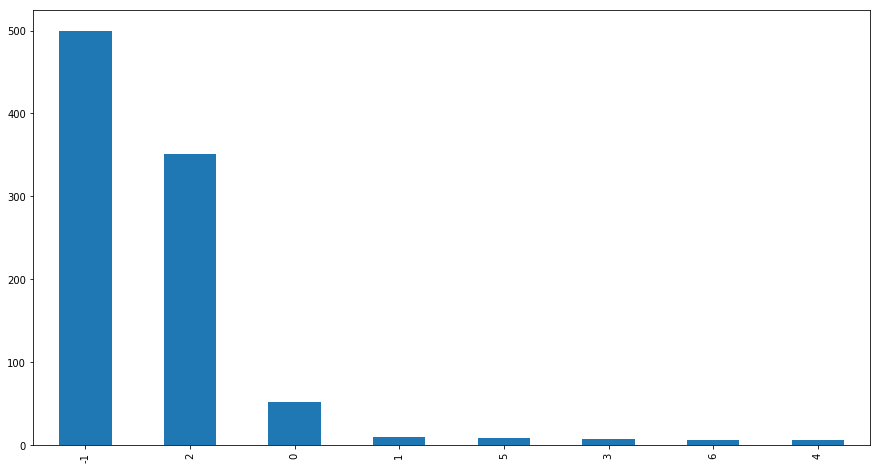

In [196]:
df_news['class'].value_counts().plot(kind = 'bar', figsize=(15,8))

In [197]:
len(df_news[df_news['class'] == 2]['title'].values)

351

In [198]:
df_news[df_news['class'] == 2]['title'].values[30:60]

array(['Céleres eleva previsão de safra de soja do Brasil; reduz previsão para milho',
       'FCStone cita clima e eleva safra de soja 17/18 do Brasil; prevê exportação maior',
       'INTL FCStone eleva previsão de safra de soja 2017/18 no Brasil para 111,08 mi t',
       'Colheita de milho verão vai a passos lentos no Paraná com produtor focado em soja',
       'Conab eleva estimativa de safra de soja 2017/18 para 113,02 mi t',
       'Conab eleva estimativa de safra de soja do país; reduz previsão de milho',
       'Estoque de milho deve cair nos EUA com maior exportação e uso para etanol, diz USDA',
       'USDA eleva safra de soja do Brasil a 113 mi t; corta a da Argentina para 47 mi t',
       'Colheita de soja do Brasil avança para 48% da área, diz AgRural',
       'Valor bruto da agropecuária do Brasil deve cair para R$515,9 bi em 2018, diz governo',
       'Safras prevê exportação recorde de 70 mi t de soja pelo Brasil',
       'Colheita de soja do Brasil avança para 58% da á

### Word cloud per bucket

In [201]:
from wordcloud import WordCloud

In [202]:
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

In [203]:
nlp = spacy.load("pt_core_news_sm")

In [204]:
def get_tokens(text, candidate_pos = ['NOUN','PRON','VERB', 'AUX']):   
    
    sentences = []        
    count_token = {}
    
    set_token = set()

    doc = nlp(text)
    
    for sent in doc.sents:
        for token in sent:
            if token.pos_ in candidate_pos and token.is_stop is False:
                set_token.add(token.lemma_)
                if token.lemma_ in count_token.keys():
                    count_token[token.lemma_] += 1
                else:
                    count_token[token.lemma_] = 1
    
    return count_token, set_token

In [206]:
text = df_news[df_news['class'] == 2]['title'].sum()

In [207]:
word_count_up =  get_tokens(text)[0]

(-0.5, 399.5, 199.5, -0.5)

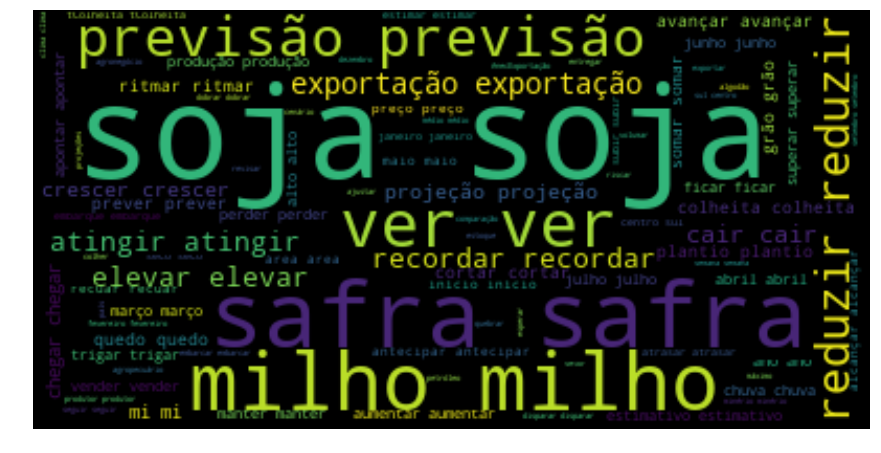

In [208]:
plt.figure(figsize=(15,15))
fake_text = ''
for word in word_count_up.keys():
    for x in range(0,word_count_up[word]):
        fake_text += word + ' '
wordcloud = WordCloud().generate(fake_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

---------------------------------------------------

### Running DBSCAN over bigger cluster

In [209]:
inner_cluster_df = df_news[df_news['class'] == 2]

In [210]:
inner_cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 197 to 3738
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         351 non-null    object        
 1   datetime      351 non-null    datetime64[ns]
 2   media         351 non-null    object        
 3   is_day_high   351 non-null    bool          
 4   is_3_high     351 non-null    bool          
 5   is_7_high     351 non-null    bool          
 6   is_14_high    351 non-null    bool          
 7   is_21_high    351 non-null    bool          
 8   norm_7_mean   351 non-null    float64       
 9   norm_3_mean   351 non-null    float64       
 10  norm_14_mean  351 non-null    float64       
 11  norm_21_mean  351 non-null    float64       
 12  mean_price    351 non-null    float64       
 13  link          351 non-null    object        
 14  class         351 non-null    int64         
dtypes: bool(5), datetime64[ns](1), float6

In [211]:
%%time
X_ada_in = []
for headline in inner_cluster_df['title'].values:
    X_ada_in.append(np.array(adaptive_avg_pool1d(l,text_to_tensor(headline)))[0])

CPU times: user 2min 27s, sys: 404 ms, total: 2min 27s
Wall time: 37.7 s


In [212]:
X_ada_in = np.array(X_ada_in)
X_ada_in.shape

(351, 768)

In [213]:
%%time
neigh = NearestNeighbors(n_neighbors = 2)
nbrs = neigh.fit(X_ada_in)
distances, indices = nbrs.kneighbors(X_ada_in)

CPU times: user 500 ms, sys: 28 µs, total: 501 ms
Wall time: 503 ms


In [214]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

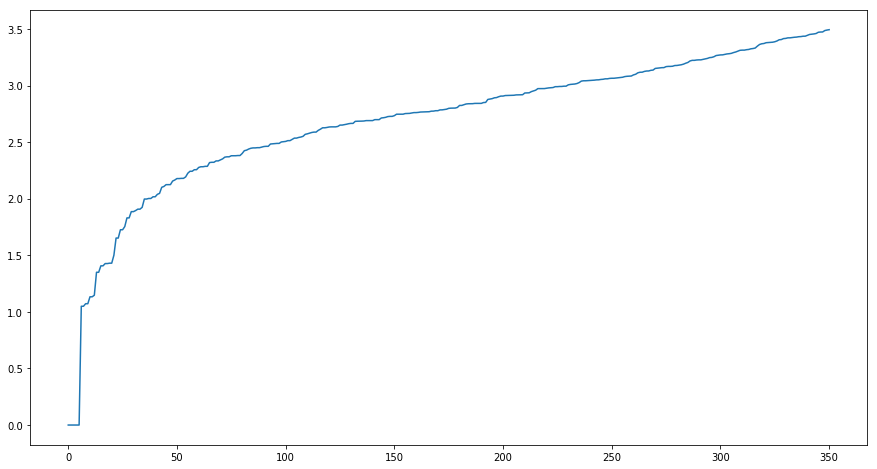

In [215]:
plt.figure(figsize=(15,8))
plt.plot(distances)

In [216]:
%%time
clustering = DBSCAN(eps = 2.7, min_samples = 5).fit(X_ada_in)

CPU times: user 635 ms, sys: 332 µs, total: 635 ms
Wall time: 654 ms


In [217]:
np.unique(clustering.labels_)

array([-1,  0,  1,  2,  3,  4])

In [218]:
inner_cluster_df['class'] = clustering.labels_
inner_cluster_df['class'].value_counts()

/home/gaivota/gaivota/work/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-1    279
 1     34
 3     17
 4      8
 0      8
 2      5
Name: class, dtype: int64

In [219]:
inner_cluster_df['class'].value_counts()

-1    279
 1     34
 3     17
 4      8
 0      8
 2      5
Name: class, dtype: int64

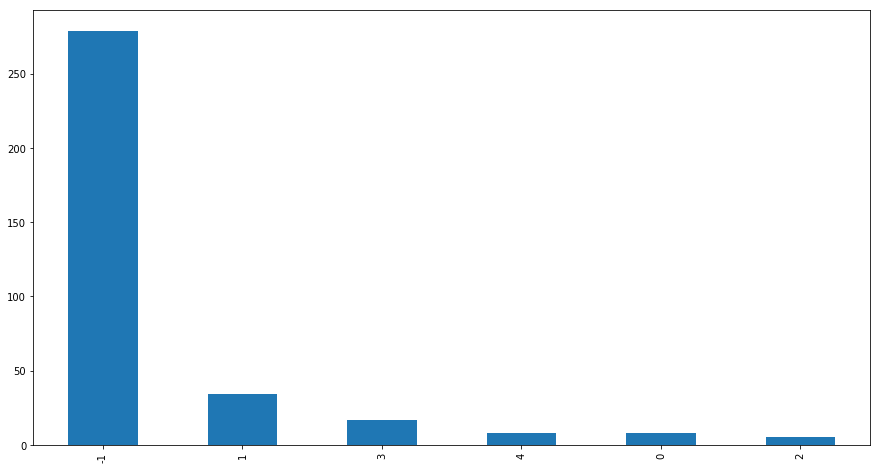

In [220]:
inner_cluster_df['class'].value_counts().plot(kind = 'bar', figsize=(15,8))

In [237]:
for hl in inner_cluster_df[inner_cluster_df['class'] == -1]['title'].values[:40]:
    print(hl)

USDA projeta queda de 4% na produção de soja do Brasil na nova safra
Estoques de soja dos EUA deverão crescer para máxima de 11 anos em 17/18, diz USDA
Importação de soja pela China cai a 7,69 mi t em junho, abaixo do esperado
USDA vê grandes safras de grãos nos EUA; preços caem
Com ritmo mais lento, venda antecipada de soja do Brasil chega a 11,3%, diz Safras
Exportação de milho do Brasil em setembro caminha para superar agosto
Estoques de milho e soja dos EUA atingem máximas de vários anos, diz USDA
Estoques de milho e soja dos EUA atingem máximas, mas ficam abaixo das previsões
Importações de soja pela China em setembro sobem 13%, acima das expectativas
Plantio de soja no Brasil avança, mas chuva irregular ainda atrapalha, diz AgRural
USDA eleva estimativa de produção de milho graças a rendimentos recordes
Brasil reduzirá produção de soja e milho em 2017/18, diz MB Agro
Venda antecipada da safra de soja 17/18 em MT atinge 32,8% do total, diz Imea
Importações de soja pela China aumen

In [238]:
text = inner_cluster_df[inner_cluster_df['class'] == -1]['title'].sum()

In [239]:
word_count_up =  get_tokens(text)[0]

(-0.5, 399.5, 199.5, -0.5)

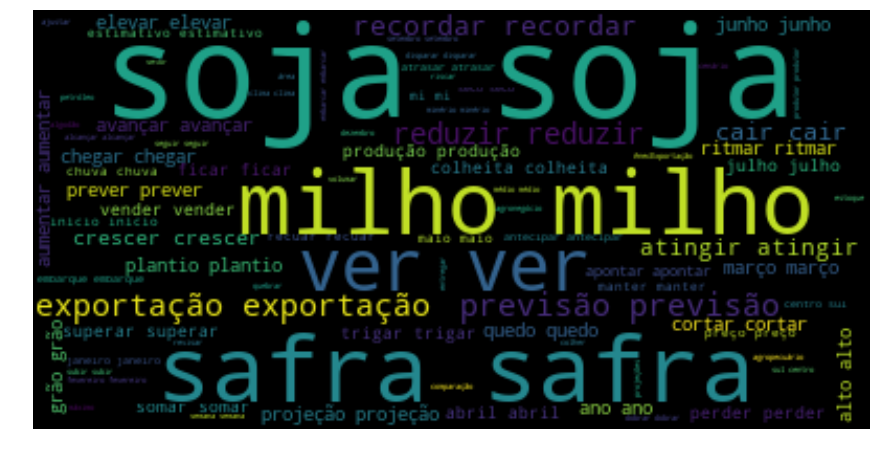

In [240]:
plt.figure(figsize=(15,15))
fake_text = ''
for word in word_count_up.keys():
    for x in range(0,word_count_up[word]):
        fake_text += word + ' '
wordcloud = WordCloud().generate(fake_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [241]:
inner_cluster_df.to_csv('low_price_3.csv', index = None)

--------------------------------------

## Exploration plots

In [56]:
max_size = -1
sizes = []
for item in tokenized_data['input_ids']:
    if max_size < len(item):
        max_size = len(item)
    sizes.append(len(item))

In [57]:
df_temp = pd.DataFrame()
for x in range(0, max_size):
    df_temp[str(x)] = None

In [58]:
for title in tokenized_data['input_ids']:
    x = 0
    row = {}
    for token in title:
        row[str(x)] = token
        x += 1
    df_temp = df_temp.append(row, ignore_index = True)

In [59]:
df_temp = df_temp.fillna(0)

In [60]:
df_temp

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,101.0,11553.0,112.0,13640.0,468.0,251.0,112.0,5995.0,22278.0,1384.0,...,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101.0,112.0,2627.0,9594.0,112.0,122.0,112.0,19589.0,22278.0,112.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101.0,8741.0,687.0,699.0,529.0,2800.0,125.0,10082.0,351.0,4755.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101.0,771.0,376.0,245.0,298.0,1426.0,6742.0,19331.0,22281.0,179.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,101.0,4470.0,9561.0,8742.0,2405.0,1206.0,180.0,1318.0,125.0,14809.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8483,101.0,482.0,22001.0,567.0,366.0,761.0,14977.0,5137.0,143.0,173.0,...,18644.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8484,101.0,11976.0,4178.0,2249.0,5488.0,222.0,6032.0,125.0,681.0,1999.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8485,101.0,19753.0,404.0,123.0,1434.0,222.0,112.0,4055.0,1125.0,22287.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8486,101.0,8169.0,1102.0,5540.0,22287.0,19367.0,173.0,2276.0,125.0,12588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
from sklearn.decomposition import PCA

In [62]:
pca = PCA(n_components = 3)
pca.fit(df_temp.values)
X_transform = pca.transform(df_temp.values)

In [63]:
df = pd.DataFrame()
for x in range(0,len(X_transform)):
    row = {}
    row['x'] = X_transform[x][0]
    row['y'] = X_transform[x][1]
    row['z'] = X_transform[x][2]
    df = df.append(row, ignore_index = True)
    

In [64]:
df.head()

,x,y,z
0,2519.727431,1747.039370,3059.421477
1,11296.882530,-3151.347288,8487.353190
2,-6100.399131,-3052.460932,4666.197512
3,9826.405863,-10461.847097,4762.593317
4,2488.545868,4180.409898,4887.468721


In [41]:
fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z')

In [42]:
fig.write_html("cluster.html")

## Dendogram

In [43]:
import seaborn as sns; sns.set_theme(color_codes=True)

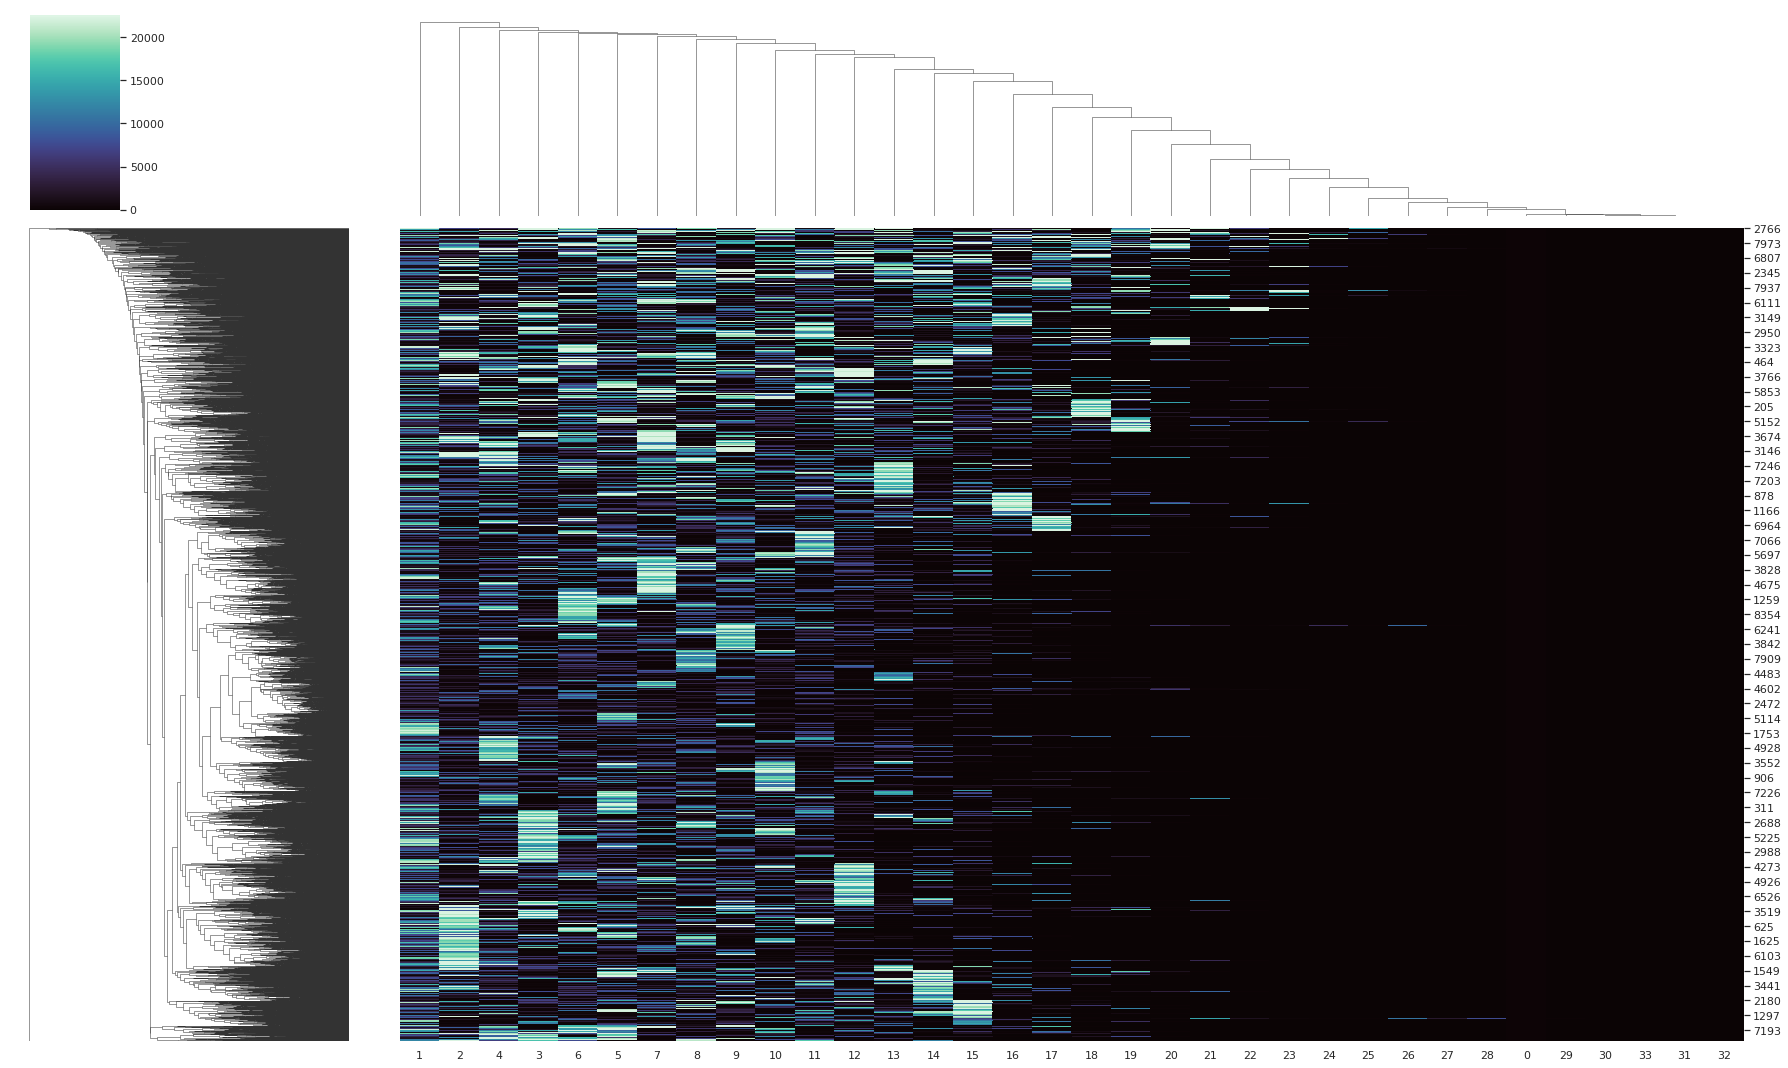

In [46]:
g = sns.clustermap(df_temp, cmap="mako", figsize = (25,15))
plt.savefig('dendogram.png')